In [1]:
import os
print(os.getcwd()) # You should be running this from the GFlowNetsA directory. 
import numpy as np
import torch
import matplotlib.pyplot as plt
try:
    from GraphClustering import GraphNet
    # print("All my friends hate hate Core GraphNet")
    # from GraphClustering.Network.Network import GraphNet # This worries me. There is an outdated version of Graphnet in Core. 
except: # Do not change this if it is unnecessary for you. Directly picking the cwd for jupyter notebooks can be a massive hassle in VSCode.
    print("Previous import statement didn't work. Changing cwd to parent directory.") # 
    for _ in range(4):
        print("Stepping one directory up.")
        try:
            os.chdir("..")
            print(os.getcwd())
            from GraphClustering import GraphNet
            print("Successful import.")
            break
        except:
            pass
from GraphClustering import IRM_graph, clusterIndex
from GraphClustering import Cmatrix_to_array, torch_posterior


c:\Users\gabri\OneDrive - Danmarks Tekniske Universitet\Lokale Filer\DTU\Forår 2023\Fagprojekt\GFlowNetsA


In [2]:
# I could just install nbimporter to import this function. 
def allPermutations(n):
    perm = [[[1]]]
    for i in range(n-1):
        perm.append([])
        for partial in perm[i]:
            for j in range(1, max(partial) + 2):
                perm[i + 1].append(partial + [j])

    return np.array(perm[-1])-1

tensor([0., 1., 2.])


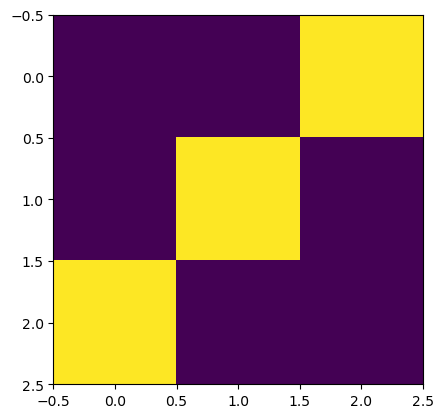

In [3]:
# Making the graph, and outputting cluster indexes.
N =  3
a, b, alpha = 0.5, 0.5, 3
log = True
adjacency_matrix, clusters = IRM_graph(alpha = alpha, a = a, b = b, N = N)
cluster_idxs = clusterIndex(clusters)
clusters = len(clusters)
plt.imshow(adjacency_matrix)
print(cluster_idxs)

net = GraphNet(n_nodes=adjacency_matrix.size()[0], a = a, b = b, alpha = alpha)

tensor([1., 2., 3.])


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_1644\3666193341.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clustering_matrix = net.get_clustering_matrix(torch.tensor(cluster_idxs+1), torch.tensor(clusters))


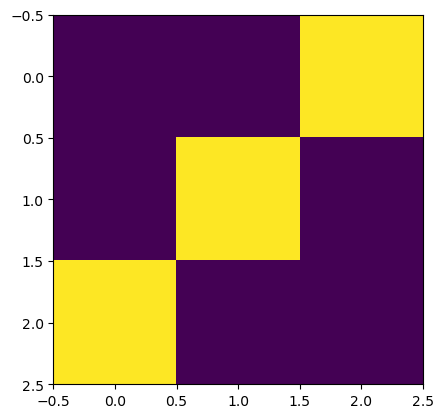

tensor([1., 2., 3.])


In [4]:
idxs = torch.randperm(N, dtype=torch.int64)
A_random = adjacency_matrix[idxs][:, idxs]

# print(torch.tensor(cluster_idxs))
# print(torch.tensor(clusters))
clustering_matrix = net.get_clustering_matrix(torch.tensor(cluster_idxs+1), torch.tensor(clusters))
# plt.figure()
# plt.imshow(clustering_matrix)
# plt.show()
cluster_random, cluster_num = net.get_clustering_list(clustering_matrix[idxs][:, idxs])
print(cluster_random)

plt.figure()
plt.imshow(A_random)
plt.show()
print(cluster_random)

In [5]:
# Computing posteriors for all clusters.
clusters_all = allPermutations(N)
Bell = len(clusters_all)
clusters_all_post = np.zeros(Bell)
for i, cluster in enumerate(clusters_all):
    posterior = (torch_posterior(adjacency_matrix, cluster, a=torch.tensor(a), b=torch.tensor(b), alpha = torch.tensor(alpha), log=True))
    clusters_all_post[i] = posterior

[        -inf  -4.85203028  -2.65480566  -4.85203028 -17.44807434]
[        -inf  -2.39789561  -0.200671    -2.39789561 -14.99393968]
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [0 1 2]]


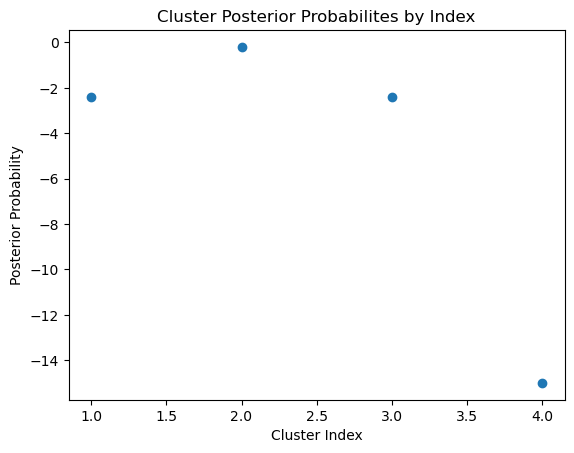

[[0 0 0]
 [0 1 2]
 [0 0 1]
 [0 1 1]
 [0 1 0]]


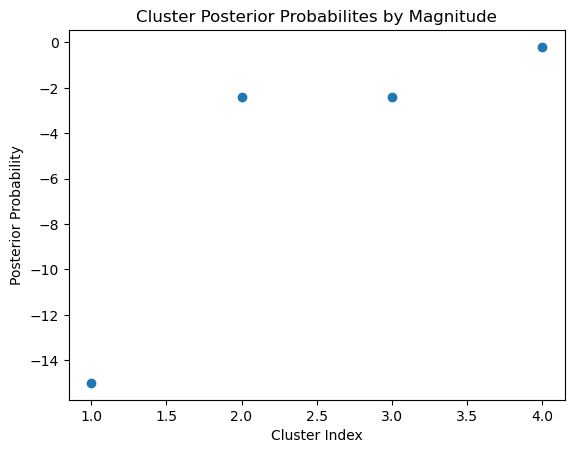

In [6]:

print(clusters_all_post)
# cluster_post = np.exp(clusters_all_post)/np.sum(np.exp(clusters_all_post)) # Numpy can handle -np.inf. This might stop working when many of the probabilities underflow.
from scipy.special import logsumexp
cluster_post = clusters_all_post - logsumexp(clusters_all_post) # Normalize them into proper log probabilities
if not log: cluster_post = np.exp(cluster_post)
print(cluster_post)

print(clusters_all)
f = plt.figure()
plt.title('Cluster Posterior Probabilites by Index')
plt.plot(cluster_post, "o")
plt.xlabel("Cluster Index")
plt.ylabel("Posterior Probability")
plt.show()

sort_idx = np.argsort(cluster_post)
print(clusters_all[sort_idx])
f = plt.figure()
plt.title('Cluster Posterior Probabilites by Magnitude')
plt.plot(cluster_post[sort_idx], "o")
plt.xlabel("Cluster Index")
plt.ylabel("Posterior Probability")
plt.show()

In [7]:
# Results
sortidxs=np.argsort(clusters_all_post)
top = 10
print("Total possible clusters: "+str(len(sortidxs)))
print("Ground truth: "+str(cluster_idxs.tolist()))
print("Top clusterings:")
for i, idx in enumerate(np.flip(sortidxs)[:top]):
    print(str(i+1)+": "+str(clusters_all[idx]))

Total possible clusters: 5
Ground truth: [0.0, 1.0, 2.0]
Top clusterings:
1: [0 1 0]
2: [0 1 1]
3: [0 0 1]
4: [0 1 2]
5: [0 0 0]


In [10]:
X = net.sample_forward(adjacency_matrix=A_random)
net.train(X, epochs=50)

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (21) must match the existing size (18) at non-singleton dimension 0.  Target sizes: [21].  Tensor sizes: [18]

In [ ]:
from GraphClustering import GraphNet
cluster_prob_dict = net.full_sample_distribution_G(adjacency_matrix = A_random, log = True)
# net.get_all_probs(adjacency_matrix, save='FinalProbDict.pth')

  0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x18 and 21x32)

In [ ]:
dic = net.get_all_probs(adjacency_matrix)

In [ ]:
net.get_all_probs(adjacency_matrix, save='FinalProbDict.pth')
final_dict = torch.load('FinalProbDict.pth')